# 2D Nuclear Segmentation with Mask-RCNN

In [1]:
import os
import errno

import numpy as np

import deepcell

In [2]:
# Download the data (saves to ~/.keras/datasets)
filename = 'HeLa_S3.npz'
(X_train, y_train), (X_test, y_test) = deepcell.datasets.hela_s3.load_data(filename)

print('X.shape: {}\ny.shape: {}'.format(X_train.shape, y_train.shape))

X.shape: (5760, 216, 256, 1)
y.shape: (5760, 216, 256, 1)


### Set up filepath constants

In [3]:
# the path to the data file is currently required for `train_model_()` functions

# NOTE: Change DATA_DIR if you are not using `deepcell.datasets`
DATA_DIR = os.path.expanduser(os.path.join('~', '.keras', 'datasets'))

DATA_FILE = os.path.join(DATA_DIR, filename)

# confirm the data file is available
assert os.path.isfile(DATA_FILE)

In [4]:
# Set up other required filepaths

# If the data file is in a subdirectory, mirror it in MODEL_DIR and LOG_DIR
PREFIX = os.path.relpath(os.path.dirname(DATA_FILE), DATA_DIR)

ROOT_DIR = '/data'  # TODO: Change this! Usually a mounted volume
MODEL_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'models', PREFIX))
LOG_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'logs', PREFIX))

# create directories if they do not exist
for d in (MODEL_DIR, LOG_DIR):
    try:
        os.makedirs(d)
    except OSError as exc:  # Guard against race condition
        if exc.errno != errno.EEXIST:
            raise

### Set up training parameters

In [21]:
from tensorflow.keras.optimizers import SGD, Adam
from deepcell.utils.train_utils import rate_scheduler

model_name = 'mrcnn_model'
backbone = 'resnet50'  # vgg16, vgg19, resnet50, densenet121, densenet169, densenet201

n_epoch = 10  # Number of training epochs
test_size = .20  # % of data saved as test
lr = 1e-5

optimizer = Adam(lr=lr, clipnorm=0.001)

lr_sched = rate_scheduler(lr=lr, decay=0.99)

batch_size = 8

num_classes = 1  # "object" is the only class

## Create the MaskRCNN Model

In [6]:
from deepcell import model_zoo

model = model_zoo.MaskRCNN(
    backbone=backbone,
    input_shape=X_train.shape[1:],
    class_specific_filter=False,
    num_classes=num_classes)

prediction_model = model

/usr/local/lib/python3.5/dist-packages/keras_applications/resnet50.py:264: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [7]:
import tensorflow as tf
from tensorflow.python.keras import backend as K
from deepcell import losses

sigma = 3.0
alpha = 0.25
gamma = 2.0

def regress_loss(y_true, y_pred):
    # separate target and state
    regression = y_pred
    regression_target = y_true[..., :-1]
    anchor_state = y_true[..., -1]

    # filter out "ignore" anchors
    indices = tf.where(K.equal(anchor_state, 1))
    regression = tf.gather_nd(regression, indices)
    regression_target = tf.gather_nd(regression_target, indices)

    # compute the loss
    loss = losses.smooth_l1(regression_target, regression, sigma=sigma)

    # compute the normalizer: the number of positive anchors
    normalizer = K.maximum(1, K.shape(indices)[0])
    normalizer = K.cast(normalizer, dtype=K.floatx())

    return K.sum(loss) / normalizer

def classification_loss(y_true, y_pred):
    # TODO: try weighted_categorical_crossentropy
    labels = y_true[..., :-1]
    # -1 for ignore, 0 for background, 1 for object
    anchor_state = y_true[..., -1]

    classification = y_pred
    # filter out "ignore" anchors
    indices = tf.where(K.not_equal(anchor_state, -1))
    labels = tf.gather_nd(labels, indices)
    classification = tf.gather_nd(classification, indices)

    # compute the loss
    loss = losses.focal(labels, classification, alpha=alpha, gamma=gamma)

    # compute the normalizer: the number of positive anchors
    normalizer = tf.where(K.equal(anchor_state, 1))
    normalizer = K.cast(K.shape(normalizer)[0], K.floatx())
    normalizer = K.maximum(K.cast_to_floatx(1.0), normalizer)

    return K.sum(loss) / normalizer

In [8]:
from deepcell.utils.retinanet_anchor_utils import overlap
from tensorflow.python.platform import tf_logging as logging

def mask_loss(iou_threshold=0.5, mask_size=(28, 28)):
    def _mask_conditional(y_true, y_pred):
        # if there are no masks annotations, return 0; else, compute the masks loss
        loss = tf.cond(
            K.any(K.equal(K.shape(y_true), 0)),
            lambda: K.cast_to_floatx(0.0),
            lambda: _mask(y_true, y_pred, iou_threshold=iou_threshold, mask_size=mask_size)
        )
        return loss

    def _mask(y_true, y_pred, iou_threshold=0.5, mask_size=(28, 28)):
        # split up the different predicted blobs
        boxes = y_pred[:, :, :4]
        masks = y_pred[:, :, 4:]

        # split up the different blobs
        annotations  = y_true[:, :, :5]
        width        = K.cast(y_true[0, 0, 5], dtype='int32')
        height       = K.cast(y_true[0, 0, 6], dtype='int32')
        masks_target = y_true[:, :, 7:]

        # reshape the masks back to their original size
        masks_target = K.reshape(masks_target, (K.shape(masks_target)[0]* K.shape(masks_target)[1], height, width))
        masks        = K.reshape(masks, (K.shape(masks)[0]* K.shape(masks)[1], mask_size[0], mask_size[1], -1))

        # TODO: Fix batch_size > 1
        boxes        = K.reshape(boxes, (-1, K.shape(boxes)[2]))
        annotations  = K.reshape(annotations, (-1, K.shape(annotations)[2]))

        # compute overlap of boxes with annotations
        iou                  = overlap(boxes, annotations)
        argmax_overlaps_inds = K.argmax(iou, axis=1)
        max_iou              = K.max(iou, axis=1)

        # filter those with IoU > 0.5
        indices              = tf.where(K.greater_equal(max_iou, iou_threshold))
        boxes                = tf.gather_nd(boxes, indices)
        masks                = tf.gather_nd(masks, indices)
        argmax_overlaps_inds = K.cast(tf.gather_nd(argmax_overlaps_inds, indices), 'int32')
        labels               = K.cast(K.gather(annotations[:, 4], argmax_overlaps_inds), 'int32')

        # make normalized boxes
        x1 = boxes[:, 0]
        y1 = boxes[:, 1]
        x2 = boxes[:, 2]
        y2 = boxes[:, 3]
        boxes = K.stack([
            y1 / (K.cast(height, dtype=K.floatx()) - 1),
            x1 / (K.cast(width, dtype=K.floatx()) - 1),
            (y2 - 1) / (K.cast(height, dtype=K.floatx()) - 1),
            (x2 - 1) / (K.cast(width, dtype=K.floatx()) - 1),
        ], axis=1)

        # crop and resize masks_target
        masks_target = K.expand_dims(masks_target, axis=3)  # append a fake channel dimension
        masks_target = tf.image.crop_and_resize(
            masks_target,
            boxes,
            argmax_overlaps_inds,
            mask_size
        )
        masks_target = masks_target[:, :, :, 0]  # remove fake channel dimension

        # gather the predicted masks using the annotation label
        masks = tf.transpose(masks, (0, 3, 1, 2))
        label_indices = K.stack([tf.range(K.shape(labels)[0]), labels], axis=1)
        masks = tf.gather_nd(masks, label_indices)

        # compute mask loss
        mask_loss  = K.binary_crossentropy(masks_target, masks)
        normalizer = K.shape(masks)[0] * K.shape(masks)[1] * K.shape(masks)[2]
        normalizer = K.maximum(K.cast(normalizer, K.floatx()), 1)
        mask_loss  = K.sum(mask_loss) / normalizer

        return mask_loss

    return _mask_conditional

In [9]:
model.compile(loss={
    'regression': regress_loss,
    'classification': classification_loss,
    'masks': mask_loss()
}, optimizer=optimizer)

In [10]:
from deepcell import image_generators

datagen = image_generators.RetinaNetGenerator(
    rotation_range=180,
    shear_range=0,
    zoom_range=[0.8, 1.2],
    horizontal_flip=True,
    vertical_flip=True)

datagen_val = image_generators.RetinaNetGenerator(
    rotation_range=0,
    shear_range=0,
    zoom_range=0,
    horizontal_flip=0,
    vertical_flip=0)

In [11]:
from deepcell.utils.retinanet_anchor_utils import make_shapes_callback
from deepcell.utils.retinanet_anchor_utils import guess_shapes

if 'vgg' in backbone or 'densenet' in backbone:
    compute_shapes = make_shapes_callback(model)
else:
    compute_shapes = guess_shapes

train_data = datagen.flow(
    {'X': X_train, 'y': y_train},
    include_masks=True,
    compute_shapes=compute_shapes,
    batch_size=batch_size)

val_data = datagen_val.flow(
    {'X': X_test, 'y': y_test},
    include_masks=True,
    compute_shapes=compute_shapes,
    batch_size=batch_size)

In [12]:
from tensorflow.python.keras import callbacks
from deepcell.callbacks import *

tensorboard_callback = callbacks.TensorBoard(
    log_dir=os.path.join(LOG_DIR, model_name))

training_callbacks = [
    callbacks.LearningRateScheduler(lr_sched),
    callbacks.ModelCheckpoint(
        os.path.join(MODEL_DIR, '{}.h5'.format(model_name)),
        monitor='val_loss', verbose=1,
        save_best_only=True, save_weights_only=False),
    tensorboard_callback,
    callbacks.ReduceLROnPlateau(
        monitor='loss', factor=0.1,
        patience=10, verbose=1,
        mode='auto', min_delta=0.0001,
        cooldown=0, min_lr=0),
    RedirectModel(
        Evaluate(val_data,
                 iou_threshold=0.5,
                 score_threshold=0.01,
                 max_detections=100,
                 tensorboard=tensorboard_callback,
                 weighted_average=True),
        prediction_model),
]

In [22]:
# model.load_weights('/data/models/mrcnn_model.h5')

loss_history = model.fit_generator(
    train_data,
    steps_per_epoch=train_data.x.shape[0] // batch_size,
    epochs=n_epoch,
    validation_data=val_data,
    validation_steps=val_data.x.shape[0] // batch_size,
    callbacks=training_callbacks)

Epoch 1/10
644/645 [============================>.] - ETA: 0s - loss: 1.5809 - regression_loss: 0.9582 - classification_loss: 0.1434 - masks_loss: 0.4793
Epoch 00001: val_loss improved from 1.43239 to 1.26776, saving model to /data/models/mrcnn_model.h5


/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


9853 instances of class 0 with average precision: 0.7418
mAP: 0.7418
645/645 [==============================] - 548s 850ms/step - loss: 1.5809 - regression_loss: 0.9582 - classification_loss: 0.1434 - masks_loss: 0.4792 - val_loss: 1.2678 - val_regression_loss: 0.7433 - val_classification_loss: 0.1030 - val_masks_loss: 0.4215
Epoch 2/10
644/645 [============================>.] - ETA: 0s - loss: 1.4582 - regression_loss: 0.8702 - classification_loss: 0.1296 - masks_loss: 0.4584
Epoch 00002: val_loss improved from 1.26776 to 1.18124, saving model to /data/models/mrcnn_model.h5
9853 instances of class 0 with average precision: 0.7744
mAP: 0.7744
645/645 [==============================] - 492s 762ms/step - loss: 1.4582 - regression_loss: 0.8702 - classification_loss: 0.1296 - masks_loss: 0.4585 - val_loss: 1.1812 - val_regression_loss: 0.6859 - val_classification_loss: 0.0902 - val_masks_loss: 0.4052
Epoch 3/10
644/645 [============================>.] - ETA: 0s - loss: 1.3841 - regression_

In [14]:
from deepcell.training import train_model_retinanet

# model = train_model_retinanet(
#     model=model,
#     backbone=backbone,
#     dataset=DATA_FILE,  # full path to npz file
#     model_name=model_name,
#     sigma=3.0,
#     alpha=0.25,
#     gamma=2.0,
#     include_masks=True,  # include mask generation
#     weighted_average=True,
#     score_threshold=0.01,
#     iou_threshold=0.5,
#     max_detections=100,
#     test_size=test_size,
#     optimizer=optimizer,
#     batch_size=batch_size,
#     n_epoch=n_epoch,
#     log_dir=LOG_DIR,
#     model_dir=MODEL_DIR,
#     lr_sched=lr_sched,
#     rotation_range=180,
#     flip=True,
#     shear=False,
#     zoom_range=(0.8, 1.2))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image Number: 413


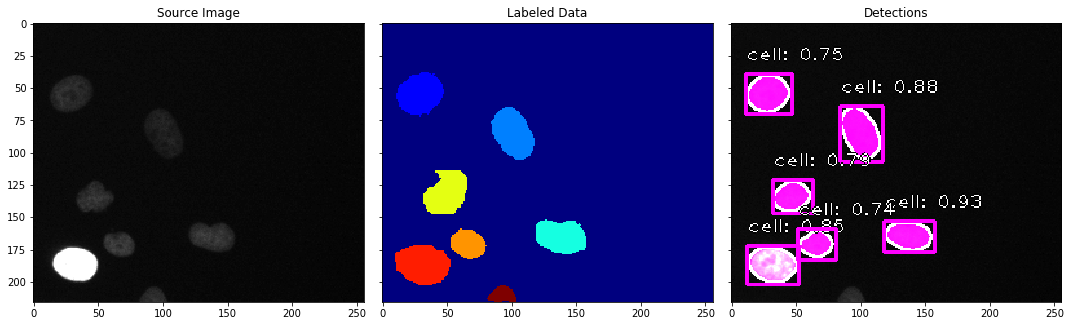

In [65]:
import matplotlib.pyplot as plt
import os
import time

import numpy as np

from deepcell.utils.plot_utils import draw_detections, draw_masks


index = np.random.randint(low=0, high=X_test.shape[0])
print('Image Number:', index)

image, mask = X_test[index:index + 1], y_test[index:index + 1]

boxes, scores, labels, masks = prediction_model.predict(image)[-4:]

image = 0.01 * np.tile(np.expand_dims(image[0, ..., 0], axis=-1), (1, 1, 3))
mask = np.squeeze(mask)

# copies to draw on
draw = image.copy()

# draw the masks
draw_masks(draw, boxes[0], scores[0], masks[0],
           score_threshold=0.5)

# draw the detections
draw_detections(draw, boxes[0], scores[0], labels[0],
                label_to_name=lambda x: 'cell',
                score_threshold=0.5,)

fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(15, 15), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(image, cmap='jet')
ax[0].set_title('Source Image')

ax[1].imshow(mask, cmap='jet')
ax[1].set_title('Labeled Data')

ax[2].imshow(draw, cmap='jet')
ax[2].set_title('Detections')

fig.tight_layout()
plt.show()